In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pykeen
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations, WN18RR
from pykeen.pipeline import pipeline
from pykeen import predict
import pandas as pd

from utils import prepare_for_visualization

/home/albert/anaconda3/envs/kg-workshop-23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-12 21:32:13.903916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 21:32:14.926521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [4]:
result = pipeline(
    dataset="Nations",
    model="TransE",
    model_kwargs={"embedding_dim": 64},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    # training_loop=training_loop,
    # training_loop_kwargs=None,
    # negative_sampler=config["negative_sampler"],
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=50,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    # evaluator=RankBasedEvaluator,
    # evaluator_kwargs=evaluator_kwargs,
    # evaluation_kwargs=evaluation_kwargs,
    # result_tracker=result_tracker,
    # evaluation_fallback=True,
    random_seed=123,
)

No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.97epoch/s, loss=0.66, prev_loss=0.656]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 4.02ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


In [6]:
save_location = "results"  # this directory
result.save_to_directory(save_location)
os.listdir(save_location)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/home/albert/anaconda3/envs/kg-workshop-23/lib/python3.11/site-packages/pykeen/datasets/nations/train.txt") to file:///home/albert/dev/pwr/kg-workshop-23/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/albert/dev/pwr/kg-workshop-23/results


['trained_model.pkl', 'results.json', 'training_triples', 'metadata.json']

In [8]:
# How to look at the model
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14, 64)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(55, 64)
    )
  )
  (weight_regularizers): ModuleList()
)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='nssa Loss'>,
        <Axes: title={'center': 'Entity/Relation Plot using PCA'}>],
       dtype=object))

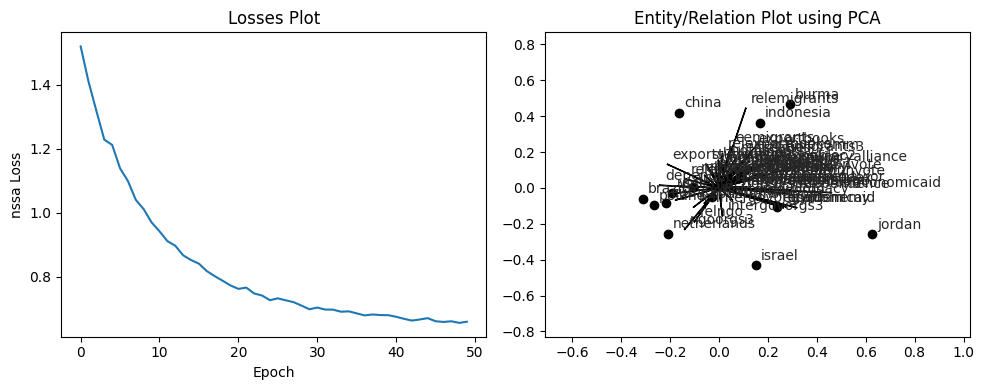

In [9]:
result.plot()

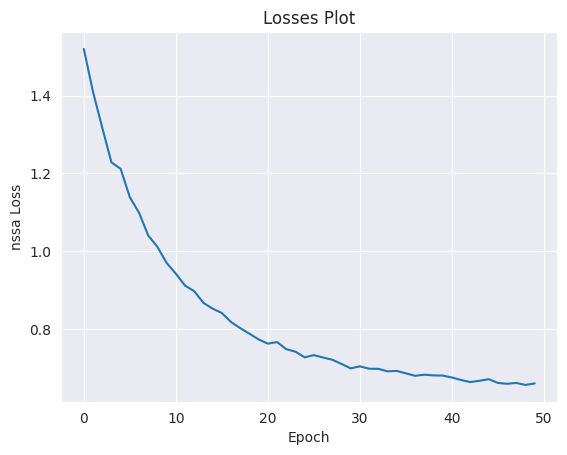

In [10]:
result.plot_losses()
plt.show()

In [11]:
metrics = result.metric_results.to_df()
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")].head()

,Side,Type,Metric,Value
5,both,realistic,inverse_arithmetic_mean_rank,0.27236
14,both,realistic,arithmetic_mean_rank,3.67164
23,both,realistic,inverse_median_rank,0.33333
32,both,realistic,inverse_harmonic_mean_rank,0.35236
41,both,realistic,z_arithmetic_mean_rank,6.48844


In [12]:
dataset = Nations()
# dataset.training.entity_id_to_label

# dataset.training.relation_id_to_label

In [13]:
result.model.entity_representations

ModuleList(
  (0): Embedding(
    (_embeddings): Embedding(14, 64)
  )
)

In [14]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]

In [20]:
prepare_for_visualization(embeddings.detach().numpy(), labels)

In [18]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# let's say your_embeddings is your array of 64-dimensional embeddings
your_embeddings = entity_embeddings  # just for demonstration purposes

# apply t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
embeddings_2d = tsne.fit_transform(your_embeddings)

# now you can create a scatter plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i in range(len(embeddings_2d)):
    plt.text(
        embeddings_2d[i, 0], embeddings_2d[i, 1], dataset.training.entity_id_to_label[i]
    )
plt.show()

NameError: name 'entity_embeddings' is not defined

In [ ]:
entity_embeddings = model.entity_representations[0]._embeddings.weight.detach().numpy()
entity_embeddings.shape